# Master Thesis: Machine Learning in Inflation Forecasting

Comparative Analysis of CNN-LSTM vs Statistical Models (ARIMA, SARIMA, VAR

To debug a cell, press Alt+Shift+Enter, or click !here goes the icon of the corresponding button in the gutter! button.
Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.


In [2]:
# R Path - required by rpy2 prior to importing libraries
import os
import os
os.environ["R_HOME"] = "/Library/Frameworks/R.framework/Resources"
os.environ["LD_LIBRARY_PATH"] = "/Library/Frameworks/R.framework/Resources/lib/"

# Basics
import numpy as np
import pandas as pd
from datetime import datetime
import joblib
import random

# Data
from pandas_datareader.data import DataReader

# R
from rpy2.robjects import pandas2ri

# Kalman Filter
from pykalman import KalmanFilter

# Machine Learning - tensorflow, keras, and sklearn
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Dense, Flatten, Lambda, MaxPooling3D, Conv3D, RepeatVector, Layer

# SKLearn Models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

# Statsmodels
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.stattools import jarque_bera
import matplotlib.dates as mdates

# Univariate GARCH

# Plots
from matplotlib import pyplot as plt
import seaborn as sns

# Misc
import warnings

from sklearn.feature_selection import RFE, mutual_info_regression
from sklearn.linear_model import LinearRegression



In [3]:

#####################################################################################################################
#                                                                                                                   #
# Data                                                                                                              #
#                                                                                                                   #
#####################################################################################################################

# Folders and worksheet names
file_path = '/Users/bodamjerry/Downloads/GermanyMacroData/'
os.chdir(file_path)
print(f"Current working directory: {os.getcwd()}")

data = pd.read_csv(
    filepath_or_buffer = file_path + 'combined' + '.csv',
    header=1,
    skiprows=[0]
)

data['DATE'] = pd.to_datetime(data['DATE'], format='%Y-%m', errors='coerce')
df_date = data['DATE']
data.set_index('DATE', inplace=True)

t_Data_Dir = 'TData/'

print(data.head(5))
print(data.tail(5))


Current working directory: /Users/bodamjerry/Downloads/GermanyMacroData
            UNERWG  ECBIRRO  ECBDFR  ECBMLFR  MMR   CPI  RETAILMV  RETAILXMV  \
DATE                                                                           
1999-01-01     8.9      3.0     2.0      4.5  160  73.9      83.2       83.6   
1999-02-01     8.8      3.0     2.0      4.5  130  74.0      83.1       83.5   
1999-03-01     8.8      3.0     2.0      4.5   60  74.0      83.3       83.7   
1999-04-01     8.8      2.5     1.5      3.5  700  74.4      83.5       83.9   
1999-05-01     8.6      2.5     1.5      3.5  570  74.4      83.4       83.8   

            RETAILGSR  RETAILGF  GOODFBT  AGRPROD  PPIIP   WPI   EPI   IPI  \
DATE                                                                         
1999-01-01       76.4      74.7     74.0     76.4   67.3  67.8  79.6  74.4   
1999-02-01       76.4      74.6     73.9     76.7   67.2  67.6  79.6  74.5   
1999-03-01       76.4      74.5     73.8     76.9   67.

In [4]:
all_columns = set(data.columns)
print(all_columns)
print(len(all_columns))
df = data.copy()
df.dropna(inplace=True)


{'RETAILGSR', 'AGRPROD', 'UNERWG', 'ECBMLFR', 'RETAILXMV', 'MMR', 'WPI', 'CPI', 'IPI', 'ECBDFR', 'GOODFBT', 'UR', 'ECBIRRO', 'PPIIP', 'RETAILMV', 'EPI', 'LTIR', 'HICP', 'RETAILGF'}
19


# Log Transformation

Performing log transformation. 
Candidate Series with zero values - zeroes are replaced with 0.001 to allow for logging and as well reduce the effect.

In [5]:
# Columns to be logged
non_rate_cols = ['MMR', 'CPI', 'RETAILMV', 'RETAILXMV', 'RETAILGSR', 'RETAILGF', 'GOODFBT',	'AGRPROD',	'PPIIP', 'WPI',	'EPI', 'IPI']

In [6]:

# Identify column with zero and replace with 0.001
df_lt = df.copy()
for col in non_rate_cols:
    if (df[col] == 0).any():
        df_lt[col] = df_lt[col].replace(0, 0.001)

# Apply log transformation
for col in non_rate_cols:
    df_lt[col] = np.log(df_lt[col])

print(df_lt.head(5))
print(df_lt.tail(5))


            UNERWG  ECBIRRO  ECBDFR  ECBMLFR       MMR       CPI  RETAILMV  \
DATE                                                                         
1999-01-01     8.9      3.0     2.0      4.5  5.075174  4.302713  4.421247   
1999-02-01     8.8      3.0     2.0      4.5  4.867534  4.304065  4.420045   
1999-03-01     8.8      3.0     2.0      4.5  4.094345  4.304065  4.422449   
1999-04-01     8.8      2.5     1.5      3.5  6.551080  4.309456  4.424847   
1999-05-01     8.6      2.5     1.5      3.5  6.345636  4.309456  4.423648   

            RETAILXMV  RETAILGSR  RETAILGF   GOODFBT   AGRPROD     PPIIP  \
DATE                                                                       
1999-01-01   4.426044   4.335983  4.313480  4.304065  4.335983  4.209160   
1999-02-01   4.424847   4.335983  4.312141  4.302713  4.339902  4.207673   
1999-03-01   4.427239   4.335983  4.310799  4.301359  4.342506  4.207673   
1999-04-01   4.429626   4.335983  4.312141  4.302713  4.330733  4.213608 

# Testing Stationarity & Differencing

In [109]:
def test_stationarity_adf(series, col, alpha=0.05):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f' {key}: {value}')
        
    is_stationary = result[1] < alpha
    print('Series:', col, is_stationary)
    return is_stationary

def test_stationarity_kpss(series, col, alpha=0.05):
    kpss_result = kpss(series, regression='c', nlags='auto')
    print('KPSS Statistic:', kpss_result[0])
    print('p-value:', kpss_result[1])
    print('Critical Values:')
    for key, value in kpss_result[3].items():
        print(f' {key}: {value}') 
    is_stationary = kpss_result[1] >= alpha  # KPSS NULL = stationary
    print('Series:', col, is_stationary)
    return is_stationary

def test_stationarity_adf_kpss(series, name, alpha=0.05):
    # ADF Test
    adf_result = adfuller(series, autolag='AIC')
    # KPSS Test
    kpss_result = kpss(series, regression='c', nlags='auto')

    # Interpret results
    is_stationary_adf = adf_result[1] < alpha
    is_stationary_kpss = kpss_result[1] >= alpha  # KPSS NULL = stationary

    print(f"Results for {name}:")
    print(f"ADF Statistic: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}, Stationary: {is_stationary_adf}")
    print(f"KPSS Statistic: {kpss_result[0]:.4f}, p-value: {kpss_result[1]:.4f}, Stationary: {is_stationary_kpss}")
    # To avoid overdifferencing, we use ADF
    return is_stationary_adf


In [110]:

def plot_series(series, df_date=None, title='Time Series'):
    plt.figure(figsize=(12, 6))
    if df_date is not None:
        # plt.plot(df_date, series, label='Time Series')
        plt.plot(df_date, series, label='Time Series')
        plt.gca().xaxis.set_major_locator(mdates.YearLocator())
        # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Customize date format
    else:
        plt.plot(series, label='Time Series')
    plt.title(title)
    plt.xlabel('Date' if df_date is not None else 'Time')
    plt.ylabel('Value')
    plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
    plt.legend()
    plt.tight_layout()       # Adjust layout to prevent clipping
    plt.show()

def difference(series):
    return series.diff().dropna()

def plot_grid_series(data, column_names=None, grid_rows=4, grid_cols=3, figsize=(18, 14)):
    """
    Plots time series for multiple columns in a DataFrame in a grid layout.

    Args:
        data (pd.DataFrame): DataFrame containing time series data.
        column_names (list, optional): List of column names to plot.
                                        If None, all columns in data are plotted. Defaults to None.
        grid_rows (int, optional): Number of rows in the subplot grid. Defaults to 4.
        grid_cols (int, optional): Number of columns in the subplot grid. Defaults to 3.
        figsize (tuple, optional): Figure size for the entire grid plot. Defaults to (18, 14).
    """

    if column_names is None:
        column_names = data.columns

    num_plots = len(column_names)
    fig, axes = plt.subplots(nrows=grid_rows, ncols=grid_cols, figsize=figsize)
    axes = axes.flatten() # Flatten the 2D array of axes to easily iterate

    for i, col_name in enumerate(column_names):
        series = data[col_name]
        ax = axes[i] # Get the current subplot axes

        # --- Ensure series.index is a DateTimeIndex ---
        if not isinstance(series.index, pd.DatetimeIndex):
            try:
                series.index = pd.to_datetime(series.index)
            except ValueError:
                print(f"Warning: Series index for {col_name} not in DateTime format. Plotting without date formatting.")
                ax.plot(series.values, label=col_name, color='#2b8cbe', linestyle='-', linewidth=1.5)
                ax.set_title(col_name, fontsize=14) # Smaller subplot title font
                ax.set_xlabel('Time', fontsize=10)   # Smaller subplot xlabel font
                ax.set_ylabel('Value', fontsize=10)  # Smaller subplot ylabel font
                ax.tick_params(axis='x', rotation=45, labelsize=8) # Smaller tick label font
                ax.grid(True, linestyle='--', alpha=0.5, color='gray')
                ax.legend(fontsize='small', frameon=True, edgecolor='black')
                continue # Skip date formatting for this subplot

        ax.plot(series.index, series.values, label=col_name, color='#2b8cbe', linestyle='-', linewidth=1.5)

        # --- Date Locator and Formatter for each subplot ---
        locator = mdates.AutoDateLocator()
        ax.xaxis.set_major_locator(locator)
        formatter = mdates.DateFormatter('%Y-%m')
        ax.xaxis.set_major_formatter(formatter)

        ax.set_title(col_name, fontsize=14) # Smaller subplot title font
        ax.set_xlabel('Date', fontsize=10)   # Smaller subplot xlabel font
        ax.set_ylabel('Value', fontsize=10)  # Smaller subplot ylabel font

        ax.tick_params(axis='x', rotation=45, labelsize=8) # Smaller tick label font
        ax.grid(True, linestyle='--', alpha=0.5, color='gray')
        ax.legend(fontsize='small', frameon=True, edgecolor='black')

        # --- Customize Spines for each subplot ---
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_linewidth(0.5)
        ax.spines['left'].set_linewidth(0.5)

    # Remove any unused subplots if num_plots is less than grid_rows * grid_cols
    for j in range(num_plots, grid_rows * grid_cols):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout for better spacing, make room for suptitle
    plt.suptitle('Time Series Grid', fontsize=18) # Overall title for the grid
    plt.show()


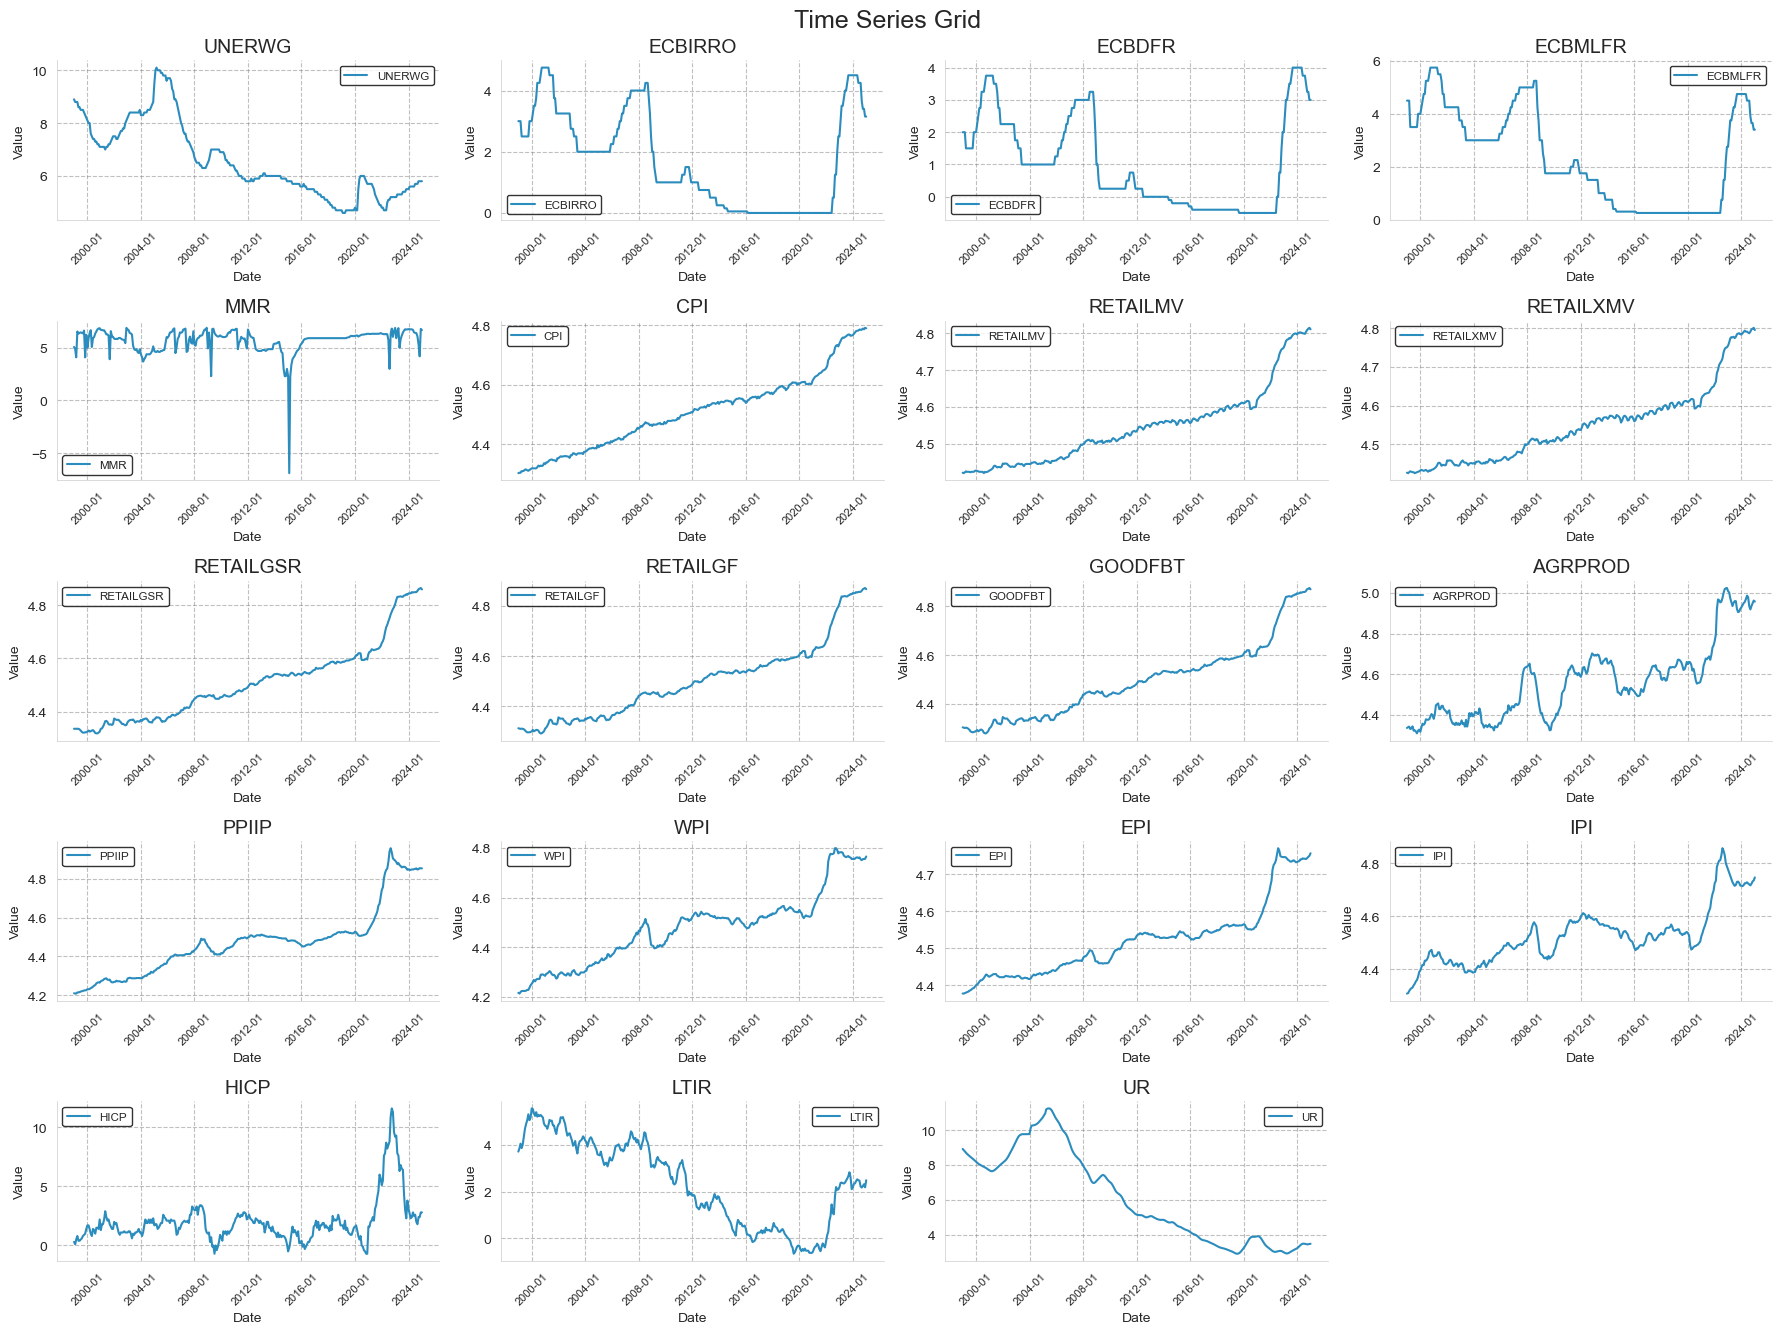

In [111]:
# --- Initial Plot ---
plot_grid_series(df_lt, grid_rows=5, grid_cols=4) # Plots all columns in a 4x3 grid (default)

In [137]:
non_stationary_series = []

for i in all_columns:
    series = pd.to_numeric(df_lt[i], errors='coerce')
    is_stationary = test_stationarity_adf_kpss(series, i)
    if not is_stationary:
        non_stationary_series.append(i)


Results for RETAILGSR:
ADF Statistic: 0.1922, p-value: 0.9718, Stationary: False
KPSS Statistic: 2.4365, p-value: 0.0100, Stationary: False
Results for AGRPROD:
ADF Statistic: -0.7674, p-value: 0.8285, Stationary: False
KPSS Statistic: 1.9864, p-value: 0.0100, Stationary: False
Results for UNERWG:
ADF Statistic: -1.7602, p-value: 0.4004, Stationary: False
KPSS Statistic: 2.0736, p-value: 0.0100, Stationary: False
Results for ECBMLFR:
ADF Statistic: -1.9599, p-value: 0.3044, Stationary: False
KPSS Statistic: 1.3269, p-value: 0.0100, Stationary: False
Results for RETAILXMV:
ADF Statistic: -0.0120, p-value: 0.9575, Stationary: False
KPSS Statistic: 2.3892, p-value: 0.0100, Stationary: False
Results for MMR:
ADF Statistic: -4.6617, p-value: 0.0001, Stationary: True
KPSS Statistic: 0.1959, p-value: 0.1000, Stationary: True
Results for WPI:
ADF Statistic: -0.5585, p-value: 0.8801, Stationary: False
KPSS Statistic: 2.3684, p-value: 0.0100, Stationary: False
Results for CPI:
ADF Statistic: 0.5

/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_2213/1724448017.py:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_2213/1724448017.py:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_2213/1724448017.py:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_2213/1724448017.p

In [138]:
print("NON Stationary Series:")
print(non_stationary_series)

NON Stationary Series:
['RETAILGSR', 'AGRPROD', 'UNERWG', 'ECBMLFR', 'RETAILXMV', 'WPI', 'CPI', 'IPI', 'ECBDFR', 'GOODFBT', 'UR', 'ECBIRRO', 'PPIIP', 'RETAILMV', 'EPI', 'LTIR', 'RETAILGF']


# First Differencing

In [139]:
df_lts = df_lt.copy()
second_non_stationary_series = []
for col in non_stationary_series:
    df_series = df_lts[col].diff().dropna()
    df_lts[col] = df_series
    # Check if it's now stationary
    if not test_stationarity_adf_kpss(df_series, col + " (log-diffed)"):
        second_non_stationary_series.append(col)
df_lts.dropna(inplace=True)

Results for RETAILGSR (log-diffed):
ADF Statistic: -2.9323, p-value: 0.0417, Stationary: True
KPSS Statistic: 0.5521, p-value: 0.0299, Stationary: False
Results for AGRPROD (log-diffed):
ADF Statistic: -11.7833, p-value: 0.0000, Stationary: True
KPSS Statistic: 0.0684, p-value: 0.1000, Stationary: True
Results for UNERWG (log-diffed):
ADF Statistic: -6.8479, p-value: 0.0000, Stationary: True
KPSS Statistic: 0.1200, p-value: 0.1000, Stationary: True
Results for ECBMLFR (log-diffed):
ADF Statistic: -4.4964, p-value: 0.0002, Stationary: True
KPSS Statistic: 0.1756, p-value: 0.1000, Stationary: True
Results for RETAILXMV (log-diffed):
ADF Statistic: -2.5236, p-value: 0.1098, Stationary: False
KPSS Statistic: 0.6667, p-value: 0.0166, Stationary: False
Results for WPI (log-diffed):
ADF Statistic: -6.5728, p-value: 0.0000, Stationary: True
KPSS Statistic: 0.0674, p-value: 0.1000, Stationary: True
Results for CPI (log-diffed):
ADF Statistic: -2.9964, p-value: 0.0352, Stationary: True
KPSS Stat

/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_2213/1724448017.py:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_2213/1724448017.py:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_2213/1724448017.py:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_2213/1724448017.p

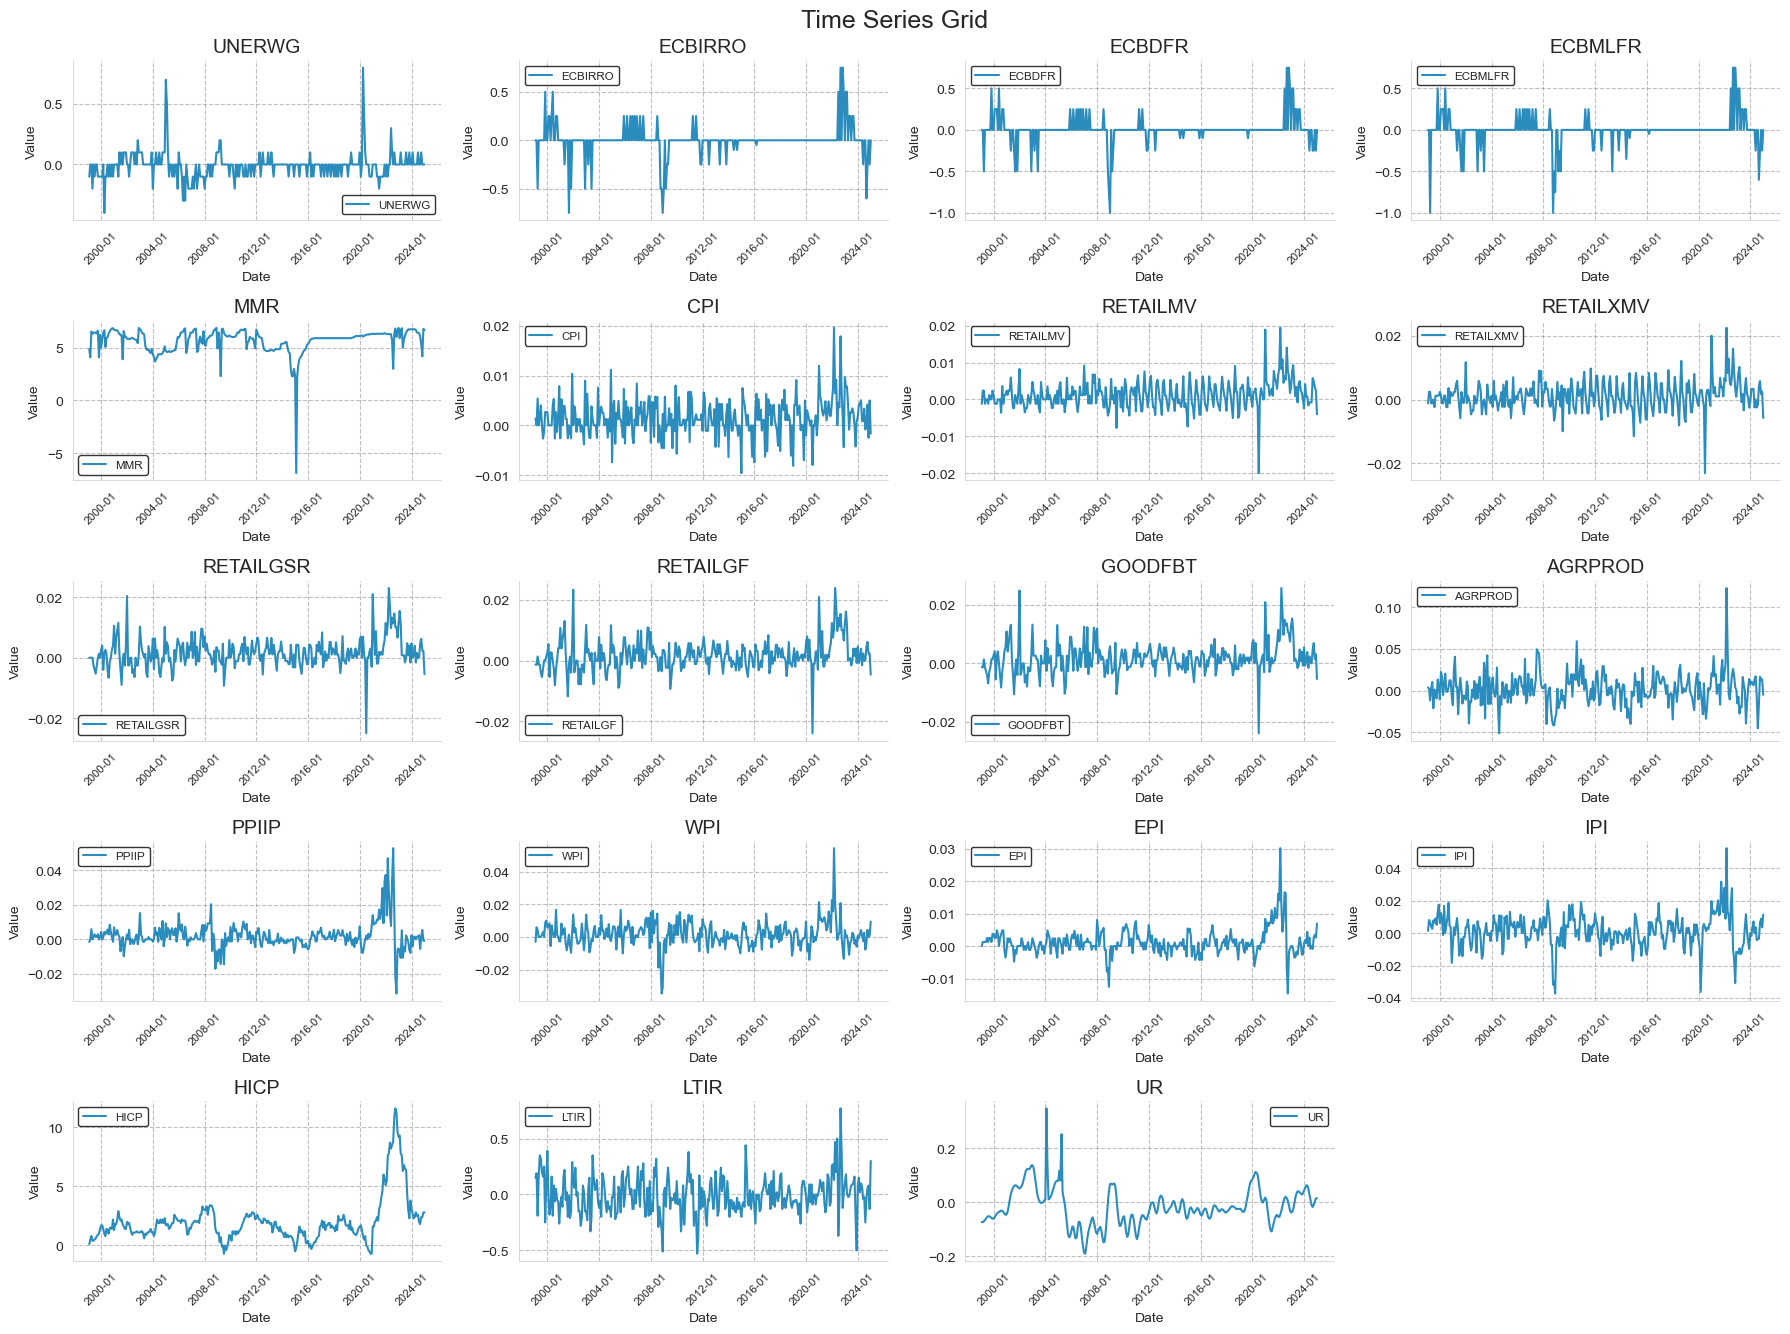

In [140]:
# --- First Plot After Differencing ---
plot_grid_series(df_lts, grid_rows=5, grid_cols=4) # Plots all columns in a 4x3 grid (default)

# Second Differencing

In [141]:
print("NON Stationary Series after First Difference:")
print(second_non_stationary_series)

NON Stationary Series after First Difference:
['RETAILXMV', 'UR', 'RETAILMV']


In [142]:
third_non_stationary_series = []
df_ltss = df_lts

for col in second_non_stationary_series:
    df_series = df_ltss[col].diff().dropna()
    df_ltss[col] = df_series
    # Check if it's now stationary
    if not test_stationarity_adf_kpss(df_series, col + " (log-diffed)"):
        third_non_stationary_series.append(col)

df_ltss.dropna(inplace=True)


Results for RETAILXMV (log-diffed):
ADF Statistic: -12.1652, p-value: 0.0000, Stationary: True
KPSS Statistic: 0.1237, p-value: 0.1000, Stationary: True
Results for UR (log-diffed):
ADF Statistic: -5.7509, p-value: 0.0000, Stationary: True
KPSS Statistic: 0.0223, p-value: 0.1000, Stationary: True
Results for RETAILMV (log-diffed):
ADF Statistic: -11.7136, p-value: 0.0000, Stationary: True
KPSS Statistic: 0.1207, p-value: 0.1000, Stationary: True


/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_2213/1724448017.py:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_2213/1724448017.py:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_2213/1724448017.py:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')


In [143]:
print("NON Stationary Series after Second Difference:")
print(third_non_stationary_series)

NON Stationary Series after Second Difference:
[]


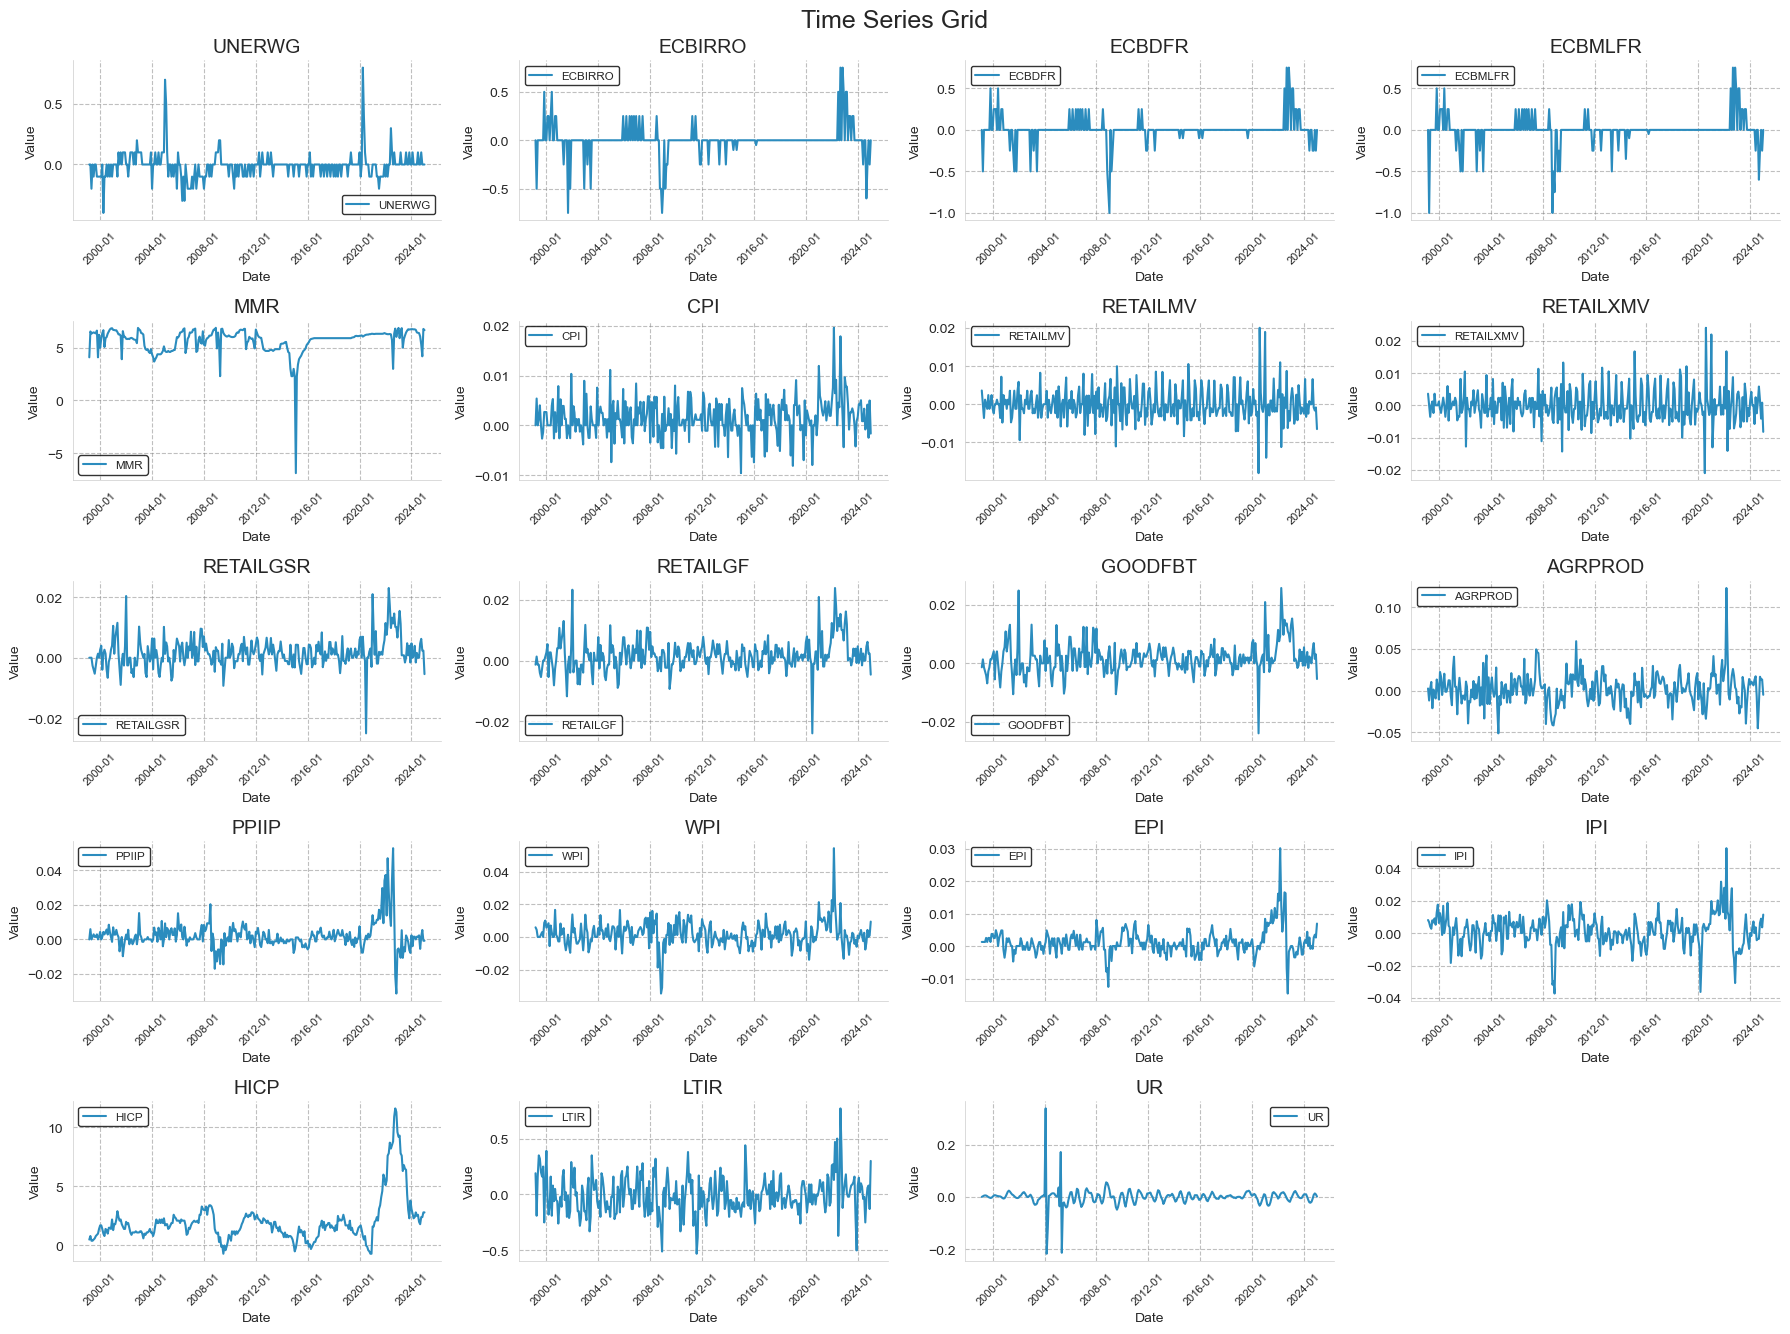

In [144]:
# --- Second Plot After Second Differencing ---
plot_grid_series(df_ltss, grid_rows=5, grid_cols=4) # Plots all columns in a 4x3 grid (default)


# Descriptive Statistics of the CPI & HICP

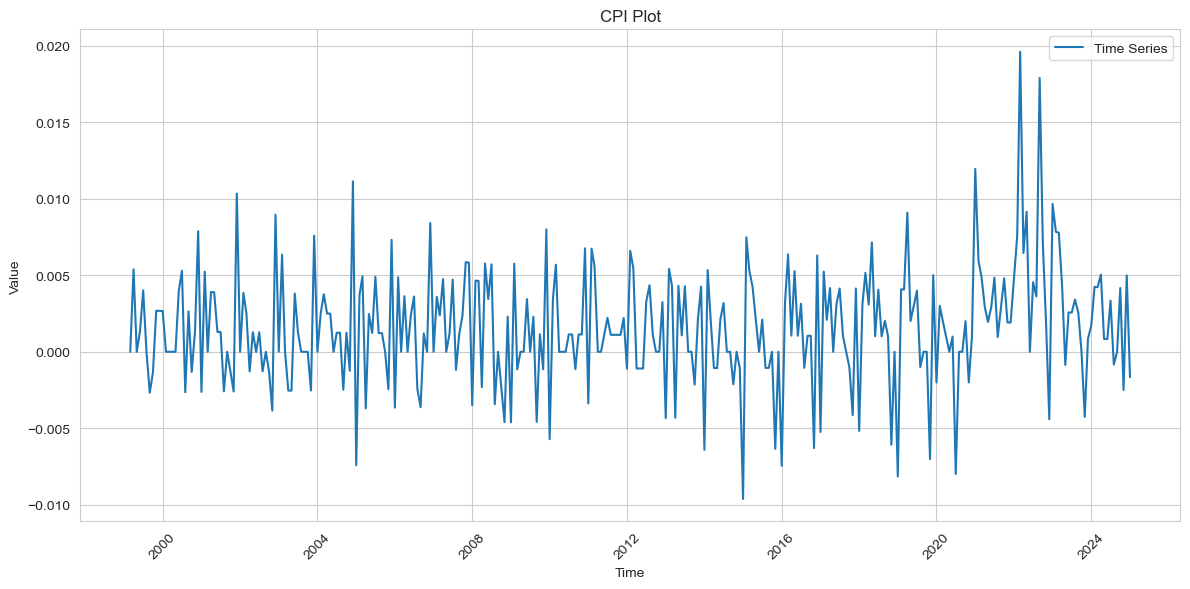

ADF Statistic: -2.979711062031099
p-value: 0.0368330657334689
Critical Values:
 1%: -3.452789844280995
 5%: -2.871421512222641
 10%: -2.5720351510944512
Series: CPI True
Stationary?
True


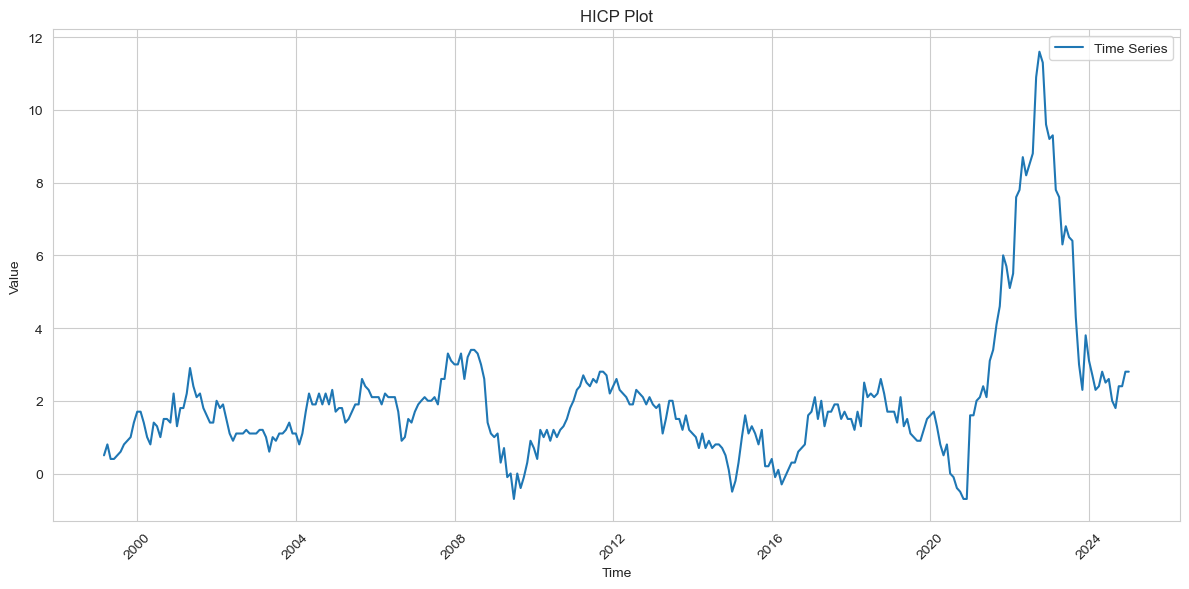

ADF Statistic: -3.2955616255796665
p-value: 0.0150780394054668
Critical Values:
 1%: -3.452636878592149
 5%: -2.8713543954331433
 10%: -2.5719993576515705
Series: HICP True
Stationary?
True


In [145]:
cpi_series = df_ltss['CPI']
plot_series(cpi_series, title="CPI Plot")
result = test_stationarity_adf(cpi_series, "CPI")
print("Stationary?")
print(result)

hicp_series = df_ltss['HICP']
plot_series(hicp_series, title="HICP Plot")
result2 = test_stationarity_adf(hicp_series, "HICP")
print("Stationary?")
print(result2)


In [146]:
# Usage
test_stationarity_kpss(cpi_series, "CPI")
test_stationarity_kpss(hicp_series, "HICP")


KPSS Statistic: 0.48292136062152646
p-value: 0.045513207067223775
Critical Values:
 10%: 0.347
 5%: 0.463
 2.5%: 0.574
 1%: 0.739
Series: CPI False
KPSS Statistic: 0.5431371584688037
p-value: 0.03195109043495411
Critical Values:
 10%: 0.347
 5%: 0.463
 2.5%: 0.574
 1%: 0.739
Series: HICP False


False

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


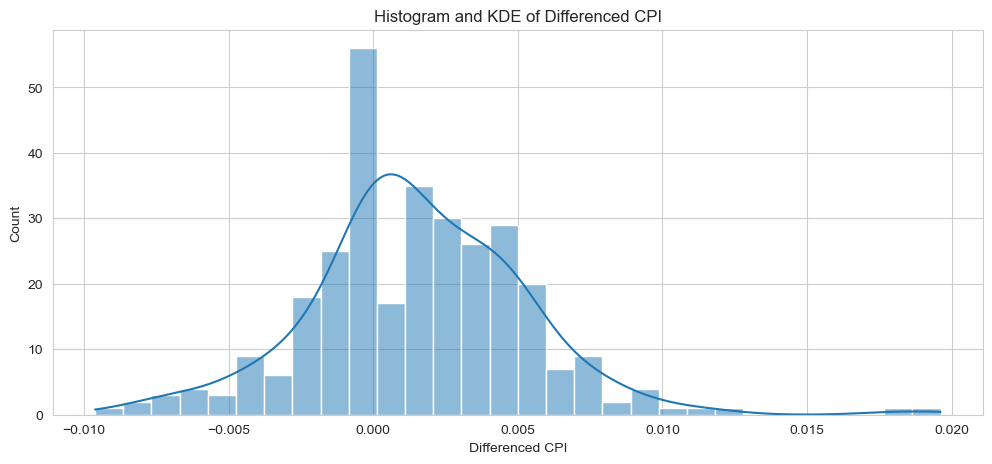

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


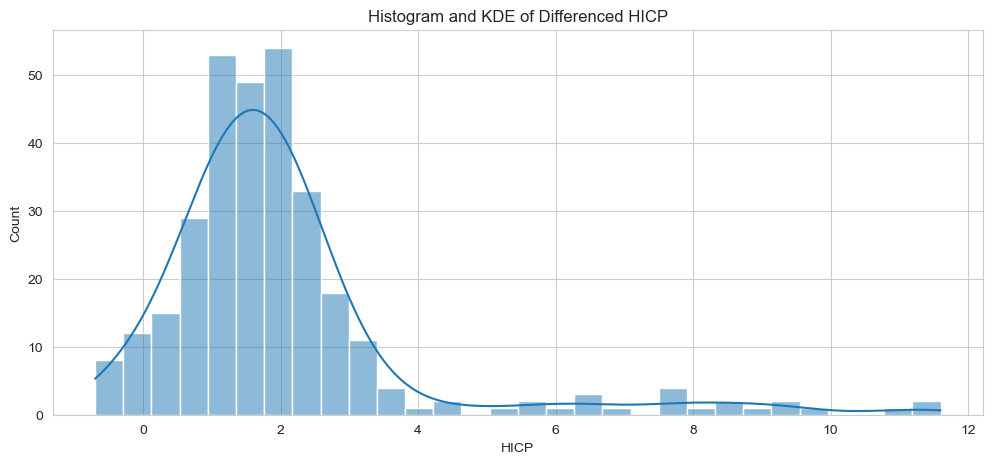

In [164]:

plt.figure(figsize=(12, 5))
sns.histplot(cpi_series, kde=True, bins=30)
plt.title('Histogram and KDE of Differenced CPI')
plt.xlabel('Differenced CPI')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(hicp_series, kde=True, bins=30)
plt.title('Histogram and KDE of Differenced HICP')
plt.xlabel('HICP')
plt.grid(True)
plt.show()


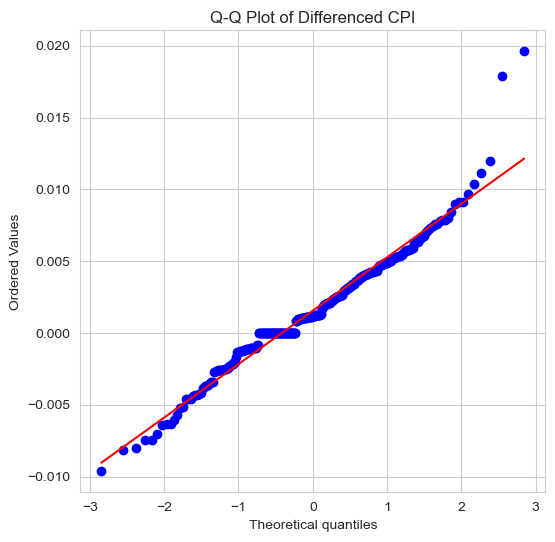

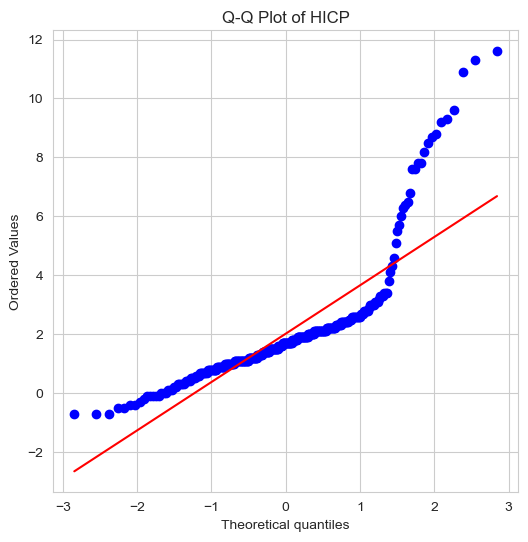

In [148]:
import scipy.stats as stats

plt.figure(figsize=(6, 6))
stats.probplot(cpi_series, dist="norm", plot=plt)
plt.title("Q-Q Plot of Differenced CPI")
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 6))
stats.probplot(hicp_series, dist="norm", plot=plt)
plt.title("Q-Q Plot of HICP")
plt.grid(True)
plt.show()


In [68]:

# Perform Jarque-Bera test
jb_stat, jb_pvalue, skew, kurtosis = jarque_bera(cpi_series)

print("Jarque-Bera Test Statistic:", jb_stat)
print("p-value:", jb_pvalue)
print("Skewness:", skew)
print("Kurtosis:", kurtosis)

# Interpretation
if jb_pvalue > 0.05:
    print("The CPI residuals are likely normally distributed (fail to reject H0).")
else:
    print("The CPI residuals are not normally distributed (reject H0).")


Jarque-Bera Test Statistic: 88.98631345870294
p-value: 4.751902815318966e-20
Skewness: 0.4550850374356383
Kurtosis: 5.457376943260477
The CPI residuals are not normally distributed (reject H0).


In [69]:

# Perform Jarque-Bera test
jb_stat, jb_pvalue, skew, kurtosis = jarque_bera(hicp_series)

print("Jarque-Bera Test Statistic:", jb_stat)
print("p-value:", jb_pvalue)
print("Skewness:", skew)
print("Kurtosis:", kurtosis)

# Interpretation
if jb_pvalue > 0.05:
    print("The HICP residuals are likely normally distributed (fail to reject H0).")
else:
    print("The HICP residuals are not normally distributed (reject H0).")


Jarque-Bera Test Statistic: 1143.8295449944364
p-value: 4.174170509897363e-249
Skewness: 2.5759361017119136
Kurtosis: 10.856717948031175
The HICP residuals are not normally distributed (reject H0).


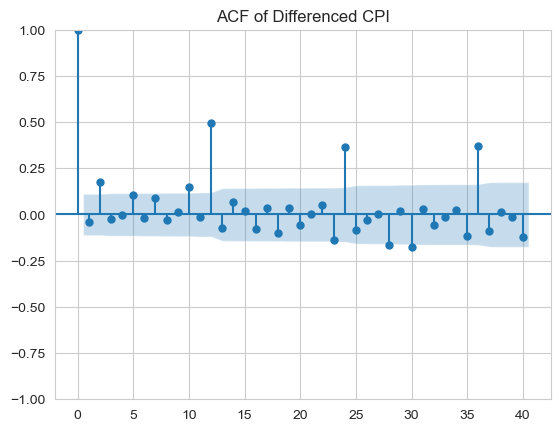

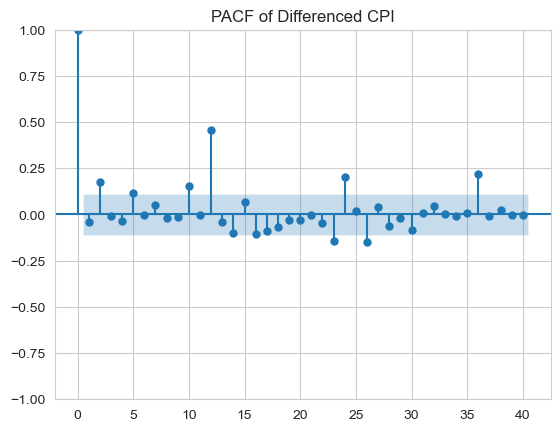

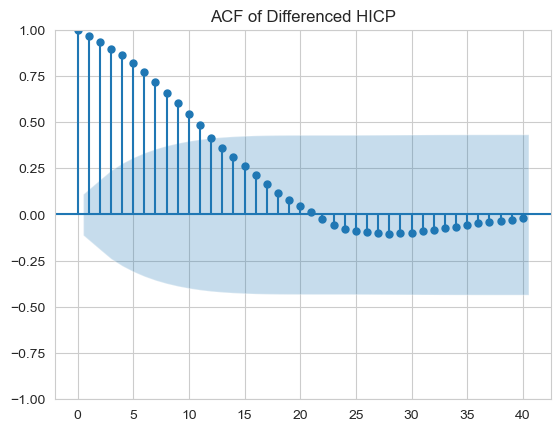

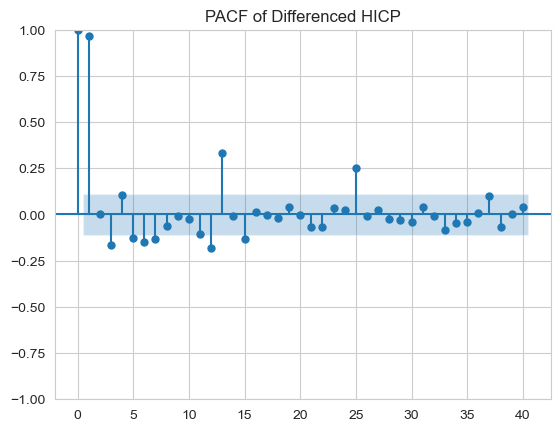

In [132]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(cpi_series, lags=40)
plt.title("ACF of Differenced CPI")
plt.show()

plot_pacf(cpi_series, lags=40, method='ywm')
plt.title("PACF of Differenced CPI")
plt.show()

plot_acf(hicp_series, lags=40)
plt.title("ACF of Differenced HICP")
plt.show()

plot_pacf(hicp_series, lags=40, method='ywm')
plt.title("PACF of Differenced HICP")
plt.show()


In [149]:
df_series = df_ltss['HICP'].diff().dropna()
df_ltss['HICP'] = df_series

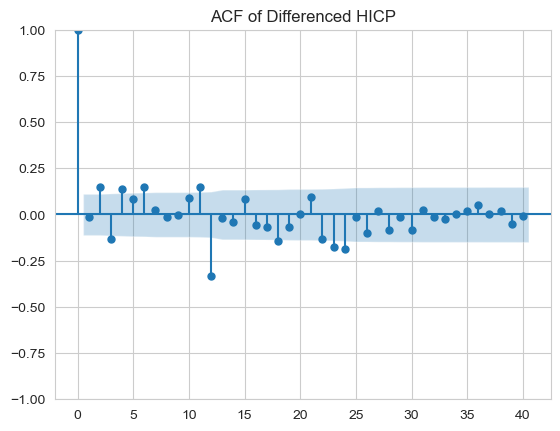

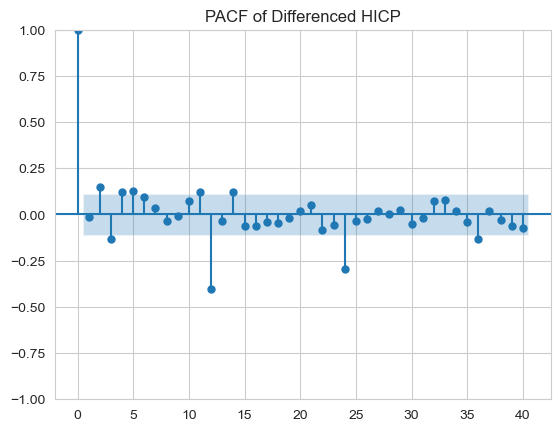

In [150]:
plot_acf(df_series, lags=40)
plt.title("ACF of Differenced HICP")
plt.show()

plot_pacf(df_series, lags=40, method='ywm')
plt.title("PACF of Differenced HICP")
plt.show()

In [91]:
def create_lag_features(df, columns, lags):
    """
    Creates lag features for specified columns in a pandas DataFrame.
    Args:
        df (pd.DataFrame): The DataFrame to add lag features to.
        columns (list): A list of column names for which to create lag features.
        lags (int): The number of lags to create
    Returns:
        pd.DataFrame: The DataFrame with added lag features.
    """
    for col in columns:
        for i in range(1, lags + 1):
            df[f'{col}_L{i}'] = df[col].shift(i)
    return df


In [151]:
print(df_ltss.columns)

Index(['UNERWG', 'ECBIRRO', 'ECBDFR', 'ECBMLFR', 'MMR', 'CPI', 'RETAILMV',
       'RETAILXMV', 'RETAILGSR', 'RETAILGF', 'GOODFBT', 'AGRPROD', 'PPIIP',
       'WPI', 'EPI', 'IPI', 'HICP', 'LTIR', 'UR'],
      dtype='object')


In [152]:
df_lagged = create_lag_features(df_ltss, df_ltss.columns, 3)

In [154]:

print(df_lagged.columns)
print(df_ltss.columns)


Index(['UNERWG', 'ECBIRRO', 'ECBDFR', 'ECBMLFR', 'MMR', 'CPI', 'RETAILMV',
       'RETAILXMV', 'RETAILGSR', 'RETAILGF', 'GOODFBT', 'AGRPROD', 'PPIIP',
       'WPI', 'EPI', 'IPI', 'HICP', 'LTIR', 'UR', 'UNERWG_L1', 'UNERWG_L2',
       'UNERWG_L3', 'ECBIRRO_L1', 'ECBIRRO_L2', 'ECBIRRO_L3', 'ECBDFR_L1',
       'ECBDFR_L2', 'ECBDFR_L3', 'ECBMLFR_L1', 'ECBMLFR_L2', 'ECBMLFR_L3',
       'MMR_L1', 'MMR_L2', 'MMR_L3', 'CPI_L1', 'CPI_L2', 'CPI_L3',
       'RETAILMV_L1', 'RETAILMV_L2', 'RETAILMV_L3', 'RETAILXMV_L1',
       'RETAILXMV_L2', 'RETAILXMV_L3', 'RETAILGSR_L1', 'RETAILGSR_L2',
       'RETAILGSR_L3', 'RETAILGF_L1', 'RETAILGF_L2', 'RETAILGF_L3',
       'GOODFBT_L1', 'GOODFBT_L2', 'GOODFBT_L3', 'AGRPROD_L1', 'AGRPROD_L2',
       'AGRPROD_L3', 'PPIIP_L1', 'PPIIP_L2', 'PPIIP_L3', 'WPI_L1', 'WPI_L2',
       'WPI_L3', 'EPI_L1', 'EPI_L2', 'EPI_L3', 'IPI_L1', 'IPI_L2', 'IPI_L3',
       'HICP_L1', 'HICP_L2', 'HICP_L3', 'LTIR_L1', 'LTIR_L2', 'LTIR_L3',
       'UR_L1', 'UR_L2', 'UR_L3'],
      dtyp

In [158]:
df = df_lagged.dropna()

In [159]:
print(len(df))
print(df.head())

307
            UNERWG  ECBIRRO  ECBDFR  ECBMLFR       MMR       CPI  RETAILMV  \
DATE                                                                         
1999-07-01    -0.1      0.0     0.0      0.0  6.461468  0.004019    0.0000   
1999-08-01     0.0      0.0     0.0      0.0  6.413459  0.000000   -0.0012   
1999-09-01     0.0      0.0     0.0      0.0  6.363028 -0.002677    0.0024   
1999-10-01    -0.1      0.0     0.0      0.0  6.633318 -0.001341   -0.0012   
1999-11-01    -0.1      0.5     0.5      0.5  4.094345  0.002681    0.0000   

            RETAILXMV  RETAILGSR  RETAILGF  ...    IPI_L3  HICP_L1  HICP_L2  \
DATE                                        ...                               
1999-07-01   0.001194  -0.003945 -0.004040  ...  0.006636      0.0     -0.4   
1999-08-01  -0.002392  -0.005284 -0.005413  ...  0.003960      0.1      0.0   
1999-09-01   0.003589  -0.002653 -0.002717  ...  0.002632      0.1      0.1   
1999-10-01  -0.000001   0.000000  0.000000  ...  0.007

In [160]:
r_State_Dir = "RState/"

In [161]:

# Define the number of rolling splits you want to create
num_splits = 100
sample_size = len(df) - num_splits

fixed_test_size = int(sample_size * 0.2)
fixed_train_size = sample_size - fixed_test_size


In [162]:
print(fixed_train_size)
print(fixed_test_size)
print(sample_size)

166
41
207


In [163]:

# 2. Scale the data using StandardScaler fitted on the *entire* dataset
# This scaler will be used to get the scaled version of each split
scaler = StandardScaler()
df_ltsx = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)

# --- Rolling Split Generation ---
total_len = len(df) # Use the length of the original data
window_size = fixed_train_size + fixed_test_size # 169 + 42 = 211

filepath_scaled = os.path.join(r_State_Dir, "data_scaled.csv")
# Save the original scaled DataFrame to CSV
df_ltsx.to_csv(filepath_scaled, index=True) # Keep index (Date) for unscaled

filepath_unscaled = os.path.join(r_State_Dir, "data_unscaled.csv")
# Save the original unscaled DataFrame to CSV
df_ltss = df[['UNERWG', 'ECBIRRO', 'ECBDFR', 'ECBMLFR', 'MMR', 'CPI', 'RETAILMV',
              'RETAILXMV', 'RETAILGSR', 'RETAILGF', 'GOODFBT', 'AGRPROD', 'PPIIP',
              'WPI', 'EPI', 'IPI', 'HICP', 'LTIR', 'UR']]
df_ltss.to_csv(filepath_unscaled, index=True) # Keep index (Date) for unscaled

# Create the rolling train-test splits
# The loop runs for the desired number of splits
for i in range(num_splits):
    # The starting index of the current rolling window
    start_idx = i

    # Calculate the ending index for the training set within the current window
    end_train_idx = start_idx + fixed_train_size

    # Calculate the ending index for the test set (and the entire window)
    end_test_idx = end_train_idx + fixed_test_size # This is start_idx + window_size

    # --- Check if the current window exceeds the total data length ---
    # If the end of the window goes beyond the total data, we stop creating splits.
    # This is <= 311, so the loop will complete all 100 iterations without breaking.
    if end_test_idx > total_len:
        print(f"Warning: Window ending at index {end_test_idx-1} exceeds total data length ({total_len}). Stopping at iteration {i}.")
        break # Exit the loop if the window goes out of bounds

    # --- Create the train and test DataFrames for the current split ---
    # Select rows from the *unscaled* DataFrame for the current window
    train_df_unscaled = df_ltss.iloc[start_idx:end_train_idx]
    test_df_unscaled = df_ltss.iloc[end_train_idx:end_test_idx]

    # Select corresponding rows from the *scaled* DataFrame for the current window
    train_df_scaled = df_ltsx.iloc[start_idx:end_train_idx]
    test_df_scaled = df_ltsx.iloc[end_train_idx:end_test_idx]

    # --- Save the combined train and test data to CSV files ---
    # Combine unscaled train and test DataFrames for saving purposes
    combined_df_unscaled = pd.concat([train_df_unscaled, test_df_unscaled])
    # Define the filename and filepath for the unscaled split (using 1-based index)
    filename_unscaled = f"time_rolling_data_unscaled_{i+1}.csv"
    filepath_unscaled = os.path.join(r_State_Dir, filename_unscaled)
    # Save the combined unscaled DataFrame to CSV
    combined_df_unscaled.to_csv(filepath_unscaled, index=True) # Keep index (Date) for unscaled

    # Combine scaled train and test DataFrames for saving purposes
    combined_df_scaled = pd.concat([train_df_scaled, test_df_scaled])
    # Define the filename and filepath for the scaled split (using 1-based index)
    filename_scaled = f"time_rolling_data_scaled_{i+1}.csv"
    filepath_scaled = os.path.join(r_State_Dir, filename_scaled)
    # Save the combined scaled DataFrame to CSV
    combined_df_scaled.to_csv(filepath_scaled, index=True) # Keep index (Date) for scaled

    print(f"Created split {i+1}: Train indices {start_idx}-{end_train_idx-1}, Test indices {end_train_idx}-{end_test_idx-1}. Saved to {filename_unscaled} and {filename_scaled}")

print("\nFinished creating rolling train-test splits.")


Created split 1: Train indices 0-165, Test indices 166-206. Saved to time_rolling_data_unscaled_1.csv and time_rolling_data_scaled_1.csv
Created split 2: Train indices 1-166, Test indices 167-207. Saved to time_rolling_data_unscaled_2.csv and time_rolling_data_scaled_2.csv
Created split 3: Train indices 2-167, Test indices 168-208. Saved to time_rolling_data_unscaled_3.csv and time_rolling_data_scaled_3.csv
Created split 4: Train indices 3-168, Test indices 169-209. Saved to time_rolling_data_unscaled_4.csv and time_rolling_data_scaled_4.csv
Created split 5: Train indices 4-169, Test indices 170-210. Saved to time_rolling_data_unscaled_5.csv and time_rolling_data_scaled_5.csv
Created split 6: Train indices 5-170, Test indices 171-211. Saved to time_rolling_data_unscaled_6.csv and time_rolling_data_scaled_6.csv
Created split 7: Train indices 6-171, Test indices 172-212. Saved to time_rolling_data_unscaled_7.csv and time_rolling_data_scaled_7.csv
Created split 8: Train indices 7-172, Tes

In [173]:

# Normalization (mean = 0 and std = 1)
# scaler = StandardScaler()
# df_ltsx = pd.DataFrame(data = scaler.fit_transform(df_ltss),
#                                index = df_ltss.index,
#                                columns = df_ltss.columns)
# 
# # Data preparation using normalized data
# # Exclude nan from the transformed time series
# df_ltsx.dropna()
# 
# # Dataframe containing target and feature variables seperately
# y = df_ltsx[["CPI", "HICP"]]
# X = df_ltsx.drop(columns = "CPI")


In [174]:
# print(df_ltsx.head())
# print(df_ltsx.isnull().values.any())
print(len(df_ltss['CPI']))

311


# Save Data & Scaler

In [170]:
# X.to_csv(t_Data_Dir + 'X.csv')
# y.to_csv(t_Data_Dir + 'y.csv')



# Creating 100 Random State

In [169]:

# data = pd.concat([X, y['CPI']], axis=1)
# df_date = pd.to_datetime(data['DATE'])
# data.set_index('DATE', inplace=True)
# data_t = data.copy()


KeyError: 'CPI'

In [ ]:

random.seed(123)
for i in range(100):
    random_state = random.randint(1, 1000)
    # Randomize data_t and save as CSV
    randomized_data = df_ltsx.sample(frac=1, random_state=random_state).reset_index(drop=True)
    randomized_data.to_csv(os.path.join(r_State_Dir, f"random_data_{i+1}.csv"), index=False)

In [ ]:

# Your scaled dataframe
df = df_ltsx.copy()
total_len = len(df)
test_size = int(total_len * 0.2)
train_size = total_len - test_size

# Output directory for random data sets
os.makedirs(r_State_Dir, exist_ok=True)

# Create 100 rolling train-test splits
for i in range(100):
    # Vary the train set start to create randomness while maintaining time order
    start_idx = i
    end_train_idx = start_idx + train_size
    end_test_idx = end_train_idx + test_size

    # Break if window exceeds total data
    if end_test_idx > total_len:
        break

    train_df = df.iloc[start_idx:end_train_idx]
    test_df = df.iloc[end_train_idx:end_test_idx]

    combined_df = pd.concat([train_df, test_df])  # for saving as single CSV
    combined_df.to_csv(os.path.join(r_State_Dir, f"time_rolling_data_{i+1}.csv"), index=False)
    

In [ ]:

# 1. Original data (transformed but unscaled)
scaler = StandardScaler()
df_ltsx = pd.DataFrame(scaler.fit_transform(df_ltss), index=df_ltss.index, columns=df_ltss.columns)

# 4. Set random seed for reproducibility
random.seed(123)

# 5. Generate 100 randomized datasets
for i in range(1, 101):
    rand_state = random.randint(1, 1000)

    # Randomize unscaled data
    randomized_unscaled = df_ltss.sample(frac=1, random_state=rand_state)
    randomized_unscaled.to_csv(os.path.join(r_State_Dir, f"random_data_unscaled_{i}.csv"))

    # Randomize scaled data
    randomized_scaled = df_ltsx.sample(frac=1, random_state=rand_state)
    randomized_scaled.to_csv(os.path.join(r_State_Dir, f"random_data_scaled_{i}.csv"))


In [ ]:
from sklearn.preprocessing import StandardScaler

for i in range(100):
    start_idx = random.randint(0, len(df_ltss) - window_size)
    window = df_ltss.iloc[start_idx:start_idx+window_size]

    # Split
    train = window.iloc[:-steps]
    test = window.iloc[-steps:]

    # Scale only CNN input
    scaler = StandardScaler()
    train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=train.columns, index=train.index)
    test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns, index=test.index)

    # Save scaled only for CNN
    train_scaled.to_csv(f"cnn_train_{i+1}.csv")
    test_scaled.to_csv(f"cnn_test_{i+1}.csv")

    # Save raw for classical models
    train.to_csv(f"classic_train_{i+1}.csv")
    test.to_csv(f"classic_test_{i+1}.csv")

joblib.dump(scaler, 'scaler.pkl')

